# OneTwoTrip Contest EDA

В соревновании OneTwoTrip все признаки анонимизированны. В этом нотбуке я постарался либо разгадать некоторые из них, либо просто изучить некоторые интересные зависимости.

In [751]:
import pandas as pd
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

In [2]:
PATH_TO_DATA = 'data/'
train = pd.read_csv(os.path.join(PATH_TO_DATA, 'onetwotrip_challenge_train.csv'))
test = pd.read_csv(os.path.join(PATH_TO_DATA, 'onetwotrip_challenge_test.csv'))

full = pd.concat([train, test])

In [3]:
train.head()

,orderid,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
0,0,10d654494cbe97bbb25d51ead2600679aff9e097924add...,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0,1,0,0,0,0
1,1,4aafc0391f72bbcf60537aece62923baf9ce644b64ac36...,144,-0.393794,5,7,2,0,0,2,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,2,121,15,1,41,3,1,0,2,1,1,0,1,0,0,0,0,0,0,0
2,2,bac8ffef46348f587c8d17137ab01fb24aef21547c647d...,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,2,17,14,1,1,11,7,0,1,1,1,0,1,1,0,0,0,0,0,0
3,3,0392247b4b87674aba2c32bf2292b105771a6a376871be...,0,-0.238651,10,11,1,1,3,2,1,0,0,19,12,3,-0.521242,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1,0,0,0,0,0,0
4,4,d1aeefef311bbeb4bd84876c8d49421f276674527d5578...,0,-0.704079,8,11,1,1,0,1,1,0,1,16,4,3,-0.801375,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1,0,0,0,0,0,0


In [4]:
train.shape

(196056, 43)

- orderid - id заказа для которого предсказывается вероятность возврата билета
- userid - id клиента
- goal1 - goal25 - целевые признаки
- indicator_goal21 - indicator_goal25 - наличие дополнительной услуги в заказе (1 - доп. услуга есть, 0 - нет)

# Field4  
Одна из первых фичей, которую интуитивно хочется добавить, это количество полетов для каждого уникального пользователя.  
Посмотрим, сколько пользователей купили всего один билет.

In [5]:
sum(train['userid'].value_counts() == 1)

78149

Это 40% от всех данных. Не очень много, но этот признак может быть полезным.

In [6]:
flight_quantity = dict(train['userid'].value_counts())
train['flight_quantity'] = train['userid'].apply(lambda x: flight_quantity[x])

Посмотрим на корреляцию количества полетов с нашими признаками

In [7]:
train.corr()[['flight_quantity']].sort_values(by='flight_quantity')

,flight_quantity
field5,-0.224035
field2,-0.087742
field29,-0.084625
indicator_goal24,-0.077879
indicator_goal25,-0.073428
goal22,-0.069466
field3,-0.067483
field16,-0.066479
field15,-0.048916
field24,-0.044923


Сразу бросается в глаза высокая корреляция с field4. Построим график их зависимости.

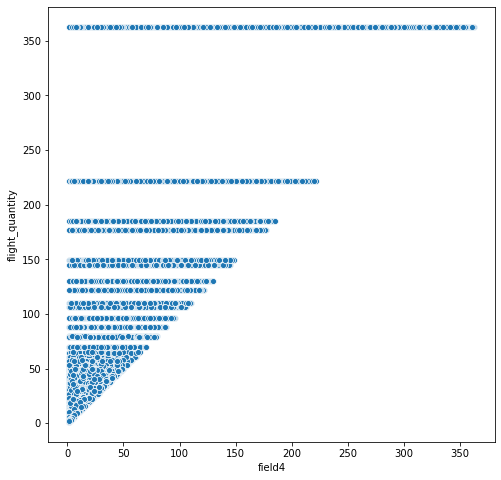

In [83]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(x='field4', y='flight_quantity', data=train);

По графику очевидно, что field4 <= flight_quantity. Давайте посмотрим, что находится в field4 для какого-нибудь одного пользователя.

In [133]:
userid_max = train['userid'].value_counts().index[0]
one_user = train[train['userid'] == userid_max]
one_user.head()

,orderid,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1,flight_quantity,field1_log
110,110,a4837464e50075c4f8b5820dab011496ba1f04a985ab27...,0,-0.393794,10,10,122,0,0,1,1,0,0,14,21,2,-0.241109,1,11,1,3,3,7,1,1,16,1,1,5,3,0,4,1,1,0,1,1,0,0,0,0,0,0,363,-0.680812
601,601,a4837464e50075c4f8b5820dab011496ba1f04a985ab27...,5,-0.471365,9,10,101,0,0,1,1,0,1,14,9,3,-0.381176,1,6,1,4,3,3,1,16,6,1,1,5,3,0,3,1,1,1,1,0,0,0,0,0,0,0,363,-0.847150
1225,1225,a4837464e50075c4f8b5820dab011496ba1f04a985ab27...,0,-0.471365,6,6,303,0,0,1,1,0,1,17,4,3,-0.381176,1,6,1,4,3,3,2,16,8,1,1,5,3,0,2,1,1,0,1,1,0,0,0,0,0,0,363,-0.847150
1306,1306,a4837464e50075c4f8b5820dab011496ba1f04a985ab27...,2,-0.316223,1,1,193,0,0,1,1,0,1,11,9,2,-0.521242,2,2,1,5,3,7,2,1,11,2,1,5,3,0,1,1,1,1,0,0,0,0,0,0,0,0,363,-0.538236
1494,1494,a4837464e50075c4f8b5820dab011496ba1f04a985ab27...,0,0.537062,4,4,266,0,0,1,1,0,0,15,3,2,0.179090,2,4,1,1,3,5,2,1,20,2,1,5,3,0,2,1,1,0,1,0,0,0,0,0,0,0,363,0.362601


In [134]:
one_user['field4'].value_counts()

363    1
114    1
116    1
117    1
118    1
      ..
244    1
245    1
246    1
247    1
1      1
Name: field4, Length: 363, dtype: int64

363 уникальных значения, каждый из которых встречается всего 1 раз. Похоже на то, что Field4 - это номер полета для конкретного человека.

# Field5

In [20]:
train['field5'].value_counts()

1    109049
0     87007
Name: field5, dtype: int64

Это бинарный признак. Давайте посмотрим, на что он влияет.  
Выведем общую информацию по данным и добавим снизу mean для field5 = 0 и field5 = 1.

In [16]:
pd.concat([train.drop(columns=['field5']).describe(), train.groupby(['field5']).mean()])

,orderid,field0,field1,field2,field3,field4,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1,flight_quantity
count,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000
mean,98027.500000,28.413163,0.000912,7.980363,7.867864,3.528966,1.577911,1.265292,0.879366,0.023937,0.448117,14.633431,12.010492,27.046028,0.001822,1.517153,15.723854,3.001301,3.811941,2.076172,3.993762,1.226471,38.751938,13.028186,1.404645,4.923456,3.875780,1.746557,0.088572,2.980837,0.994966,0.979649,0.348676,0.645754,0.647687,0.036627,0.168579,0.038713,0.022519,0.015098,0.022142,6.057932
std,56596.636526,69.603944,1.009651,2.757008,3.013659,12.692057,5.614900,0.441489,0.325702,0.164366,0.497302,5.519693,19.579464,55.490962,1.007327,0.952774,25.689926,8.510708,1.931365,0.980940,1.975246,0.418548,71.517212,6.132370,0.784647,11.652149,4.230396,1.376456,0.369773,0.919229,0.070774,0.141199,0.476552,0.478285,0.477692,0.187845,0.374381,0.192912,0.148365,0.121942,0.147144,21.779353
min,0.000000,0.000000,-0.859222,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-0.941441,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,49013.750000,0.000000,-0.471365,6.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,11.000000,4.000000,3.000000,-0.521242,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,98027.500000,0.000000,-0.238651,8.000000,8.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,15.000000,5.000000,4.000000,-0.241109,1.000000,6.000000,1.000000,4.000000,2.000000,4.000000,1.000000,17.000000,13.000000,1.000000,1.000000,2.000000,1.000000,0.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,147041.250000,13.000000,0.149205,10.000000,10.000000,2.000000,0.000000,2.000000,1.000000,0.000000,1.000000,19.000000,11.000000,26.000000,0.179090,2.000000,18.000000,1.000000,5.000000,3.000000,6.000000,1.000000,42.000000,18.000000,2.000000,1.000000,5.000000,3.000000,0.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
max,196055.000000,500.000000,82.142134,12.000000,12.000000,363.000000,323.000000,2.000000,1.000000,4.000000,1.000000,23.000000,273.000000,746.000000,55.225183,18.000000,340.000000,156.000000,7.000000,8.000000,7.000000,2.000000,867.000000,23.000000,18.000000,170.000000,28.000000,7.000000,8.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,363.000000
0,97971.057697,64.024400,-0.066941,7.078086,7.065569,6.698519,1.171630,1.249486,0.893733,0.022964,0.440263,14.563989,11.751641,27.915949,-0.027443,1.425897,14.143942,3.016481,3.780983,2.158171,3.980565,1.510315,36.845886,13.088223,1.322560,4.323054,5.239935,2.139529,0

Обратите внимание на field0 и field4.  

In [78]:
df5_0 = train[train['field5'] == 0]
df5_1 = train[train['field5'] == 1]

In [79]:
df5_1['field0'].value_counts()

0    109049
Name: field0, dtype: int64

In [80]:
df5_1['field4'].value_counts()

1    109041
2         8
Name: field4, dtype: int64

In [81]:
sum(df5_0['field0'] == 0), sum(df5_0['field4'] == 1)

(17802, 4861)

Это вполне может быть индикатором регистрации. При покупке первого билета чаще всего люди регистрируются на сайте. Но это лишь предположение.

# Field1

In [90]:
train['field1'].mean(), train['field1'].std()

(0.0009120241273193246, 1.0096508136651778)

In [92]:
full['field1'].mean(), full['field1'].std()

(-5.718476810047566e-16, 0.9999999999993084)

К этому признаку применили [Standardization](https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)).  
Вернемся к этому позже. Пока построим графики распределения и зависимостей от таргета.

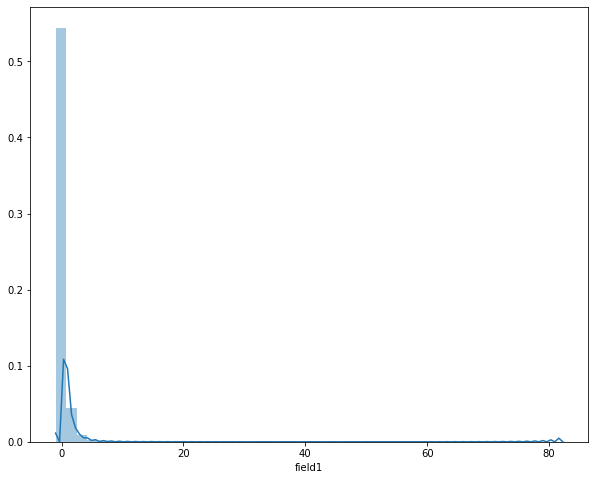

In [87]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.distplot(train['field1']);

Похоже на логнормальное распределение.

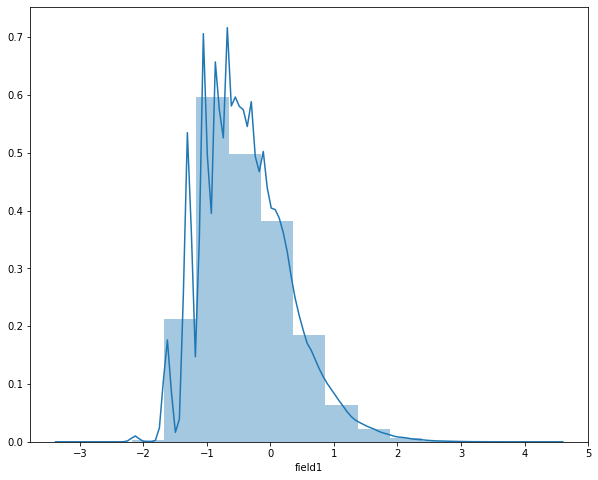

In [116]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.distplot(np.log(train['field1'] + 0.9), bins=15);

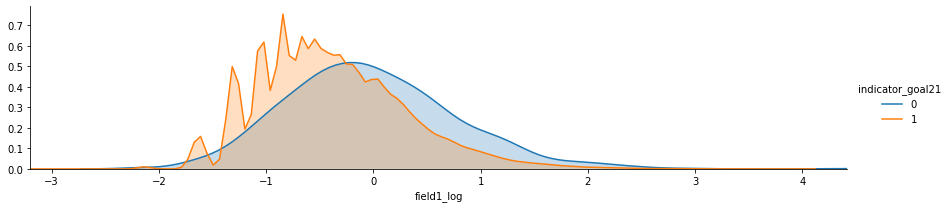

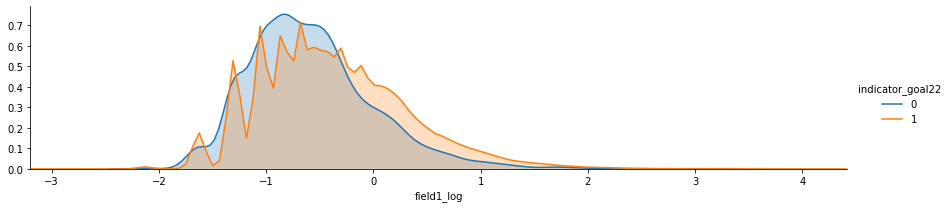

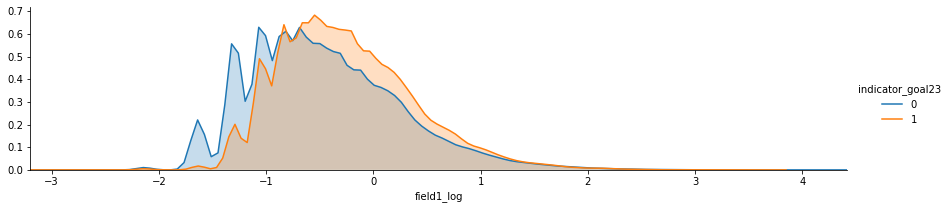

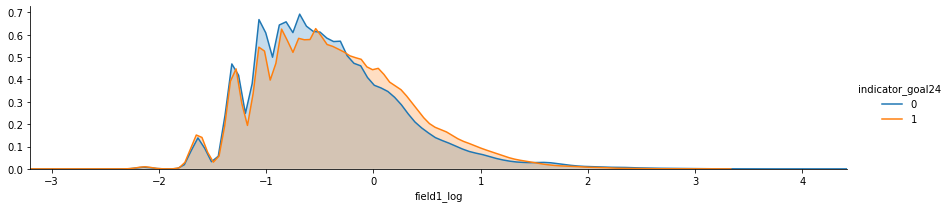

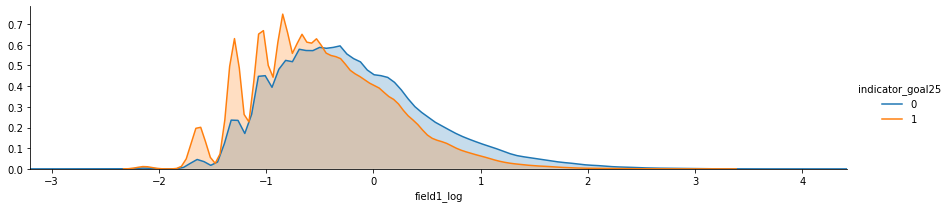

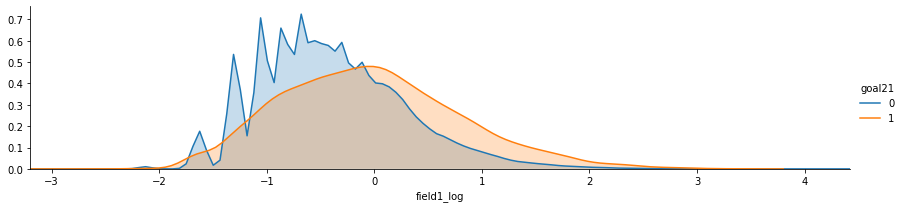

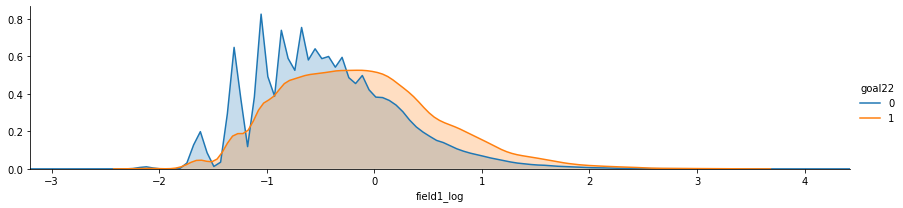

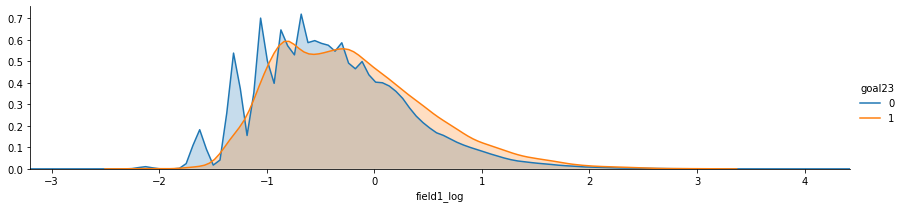

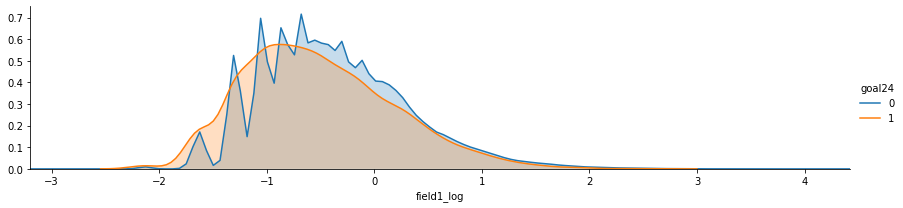

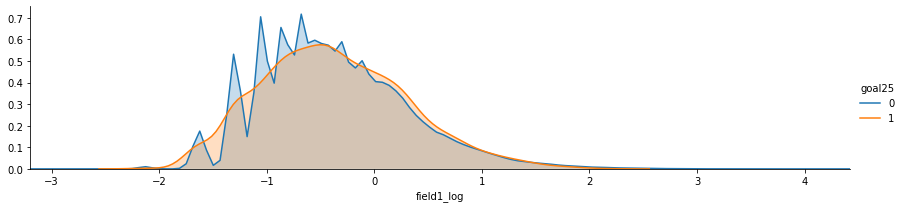

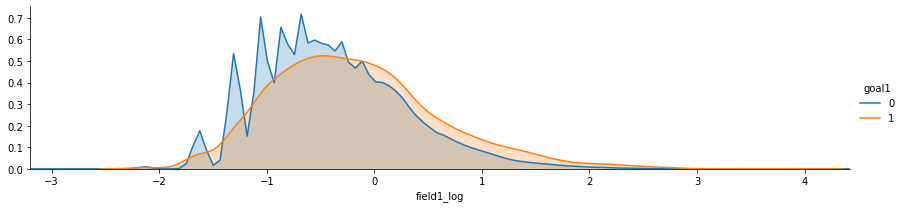

In [118]:
def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue = target, aspect = 4, row = row, col = col)
    facet.map(sns.kdeplot, var, shade = True)
    facet.set(xlim = (df[var].min(), df[var].max()))
    facet.add_legend()
    plt.show()

goals = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23', 'indicator_goal24', 'indicator_goal25',
         'goal21', 'goal22', 'goal23', 'goal24', 'goal25', 'goal1']
indicators_goals = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23', 'indicator_goal24',
                    'indicator_goal25']

train['field1_log'] = np.log(train['field1'] + 0.9)
for column in goals:
    plot_distribution(train, 'field1_log', column)

Давайте более детально изучим зависимость field1 от таргета. Для этого разобьем train на части с помощью квантилей field1.  
Возьмем [0%, 5%], [0%, 25%], [25%, 75%], [75%, 100%], [95%, 100%] и выведем по ним mean и std.

In [120]:
def df_quant(df, column, q1, q2):
    return df[(df[column].quantile(q1) < df[column]) & (df[column] <= df[column].quantile(q2))]

def df_groupby_quant(df, columns, column_by='field1'):
    
    df_05 = df_quant(df, column_by, 0, 0.05)
    df_25 = df_quant(df, column_by, 0, 0.25)
    df_25_75 = df_quant(df, column_by, 0.25, 0.75)
    df_75 = df_quant(df, column_by, 0.75, 1)
    df_95 = df_quant(df, column_by, 0.95, 1)
    
    row_list = []
    for df_i in [df_05, df_25, df_25_75, df_75, df_95]:
        row_dict = dict()
        for column in columns:
            row_dict[f'{column}_mean'] = df_i[column].mean()
            row_dict[f'{column}_std'] = df_i[column].std()
        row_list.append(row_dict)

    pd.set_option('display.max_columns', 50)
    return pd.DataFrame(row_list, index=['0_05', '0_25', '25_75', '75_100', '95_100'])

df_groupby_quant(train, goals)

,indicator_goal21_mean,indicator_goal21_std,indicator_goal22_mean,indicator_goal22_std,indicator_goal23_mean,indicator_goal23_std,indicator_goal24_mean,indicator_goal24_std,indicator_goal25_mean,indicator_goal25_std,goal21_mean,goal21_std,goal22_mean,goal22_std,goal23_mean,goal23_std,goal24_mean,goal24_std,goal25_mean,goal25_std,goal1_mean,goal1_std
0_05,0.997519,0.049746,0.973789,0.159766,0.117763,0.322334,0.635900,0.481188,0.814697,0.388552,0.024011,0.153088,0.084344,0.277909,0.014978,0.121467,0.036696,0.188018,0.017318,0.130457,0.014744,0.120528
0_25,0.997275,0.052133,0.972604,0.163236,0.242852,0.428810,0.613999,0.486835,0.740908,0.438140,0.023460,0.151359,0.109808,0.312653,0.030918,0.173098,0.028862,0.167421,0.014630,0.120069,0.016368,0.126886
25_75,0.995335,0.068143,0.979584,0.141419,0.391784,0.488152,0.644032,0.478808,0.639502,0.480148,0.030867,0.172959,0.163111,0.369469,0.037933,0.191035,0.019850,0.139484,0.015094,0.121927,0.021208,0.144079
75_100,0.991021,0.094332,0.989599,0.101457,0.411633,0.492135,0.693426,0.461076,0.533782,0.498863,0.066276,0.248766,0.261279,0.439337,0.051118,0.220241,0.018914,0.136222,0.015758,0.124538,0.032026,0.176072
95_100,0.986800,0.114136,0.992229,0.087814,0.378859,0.485129,0.673409,0.468991,0.404833,0.490886,0.105493,0.307204,0.324888,0.468358,0.060464,0.238357,0.016606,0.127798,0.013306,0.114589,0.046413,0.210388


По многим столбцам mean и std заметна монотонная зависимость.  
Наиболее сильно она выражена в:
- indicator_goal24_mean
- indicator_goal25_mean
- goal21_mean
- goal22_mean
- goal23_mean
- goal24_mean
- goal1_mean  

При изучении этой таблицы и предыдущих графиков появилось предположение, что field1 может быть отмасштабированной ценой полета.  
Видно, что при большей цене, количество приобретенных первых трех услуг в среднем возрастает. И количество последних двух в среднем наоборот падает. Но одна из них (goal25) гораздо реже предоставляется у дорогих билетов (возможно она включена в стоимость).  
Изучим связь field1 с другими признаками, чтобы проверить эту теорию.

# Field1 и Field14  
Эти два признака имеют высокую корреляцию.

In [212]:
train[['field1', 'field14']].corr()

,field1,field14
field1,1.000000,0.778125
field14,0.778125,1.000000


Построим график зависимости

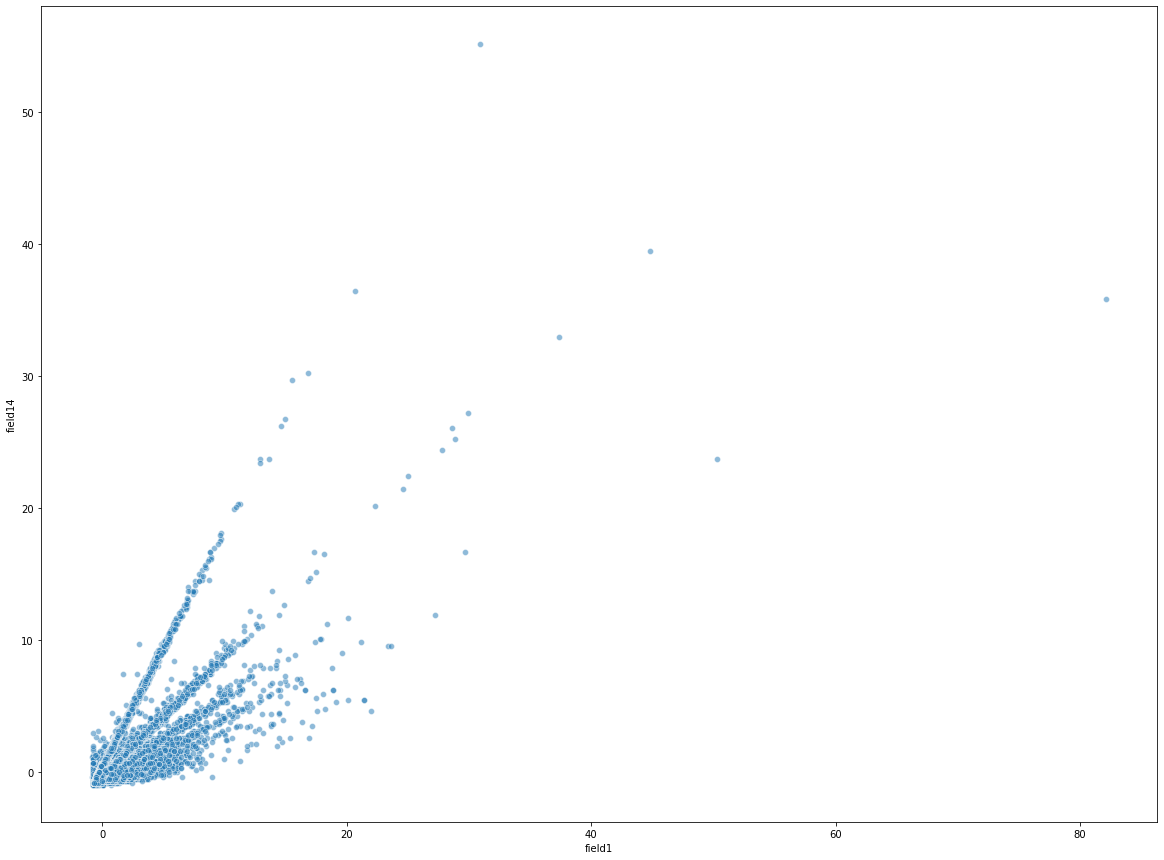

In [217]:
plt.figure(figsize=(20, 15))
sns.scatterplot(x='field1', y='field14', data=train, alpha=0.5);

Хорошо видно несколько линий.  
(Серые добавлены для дальнейшего сбора шума)

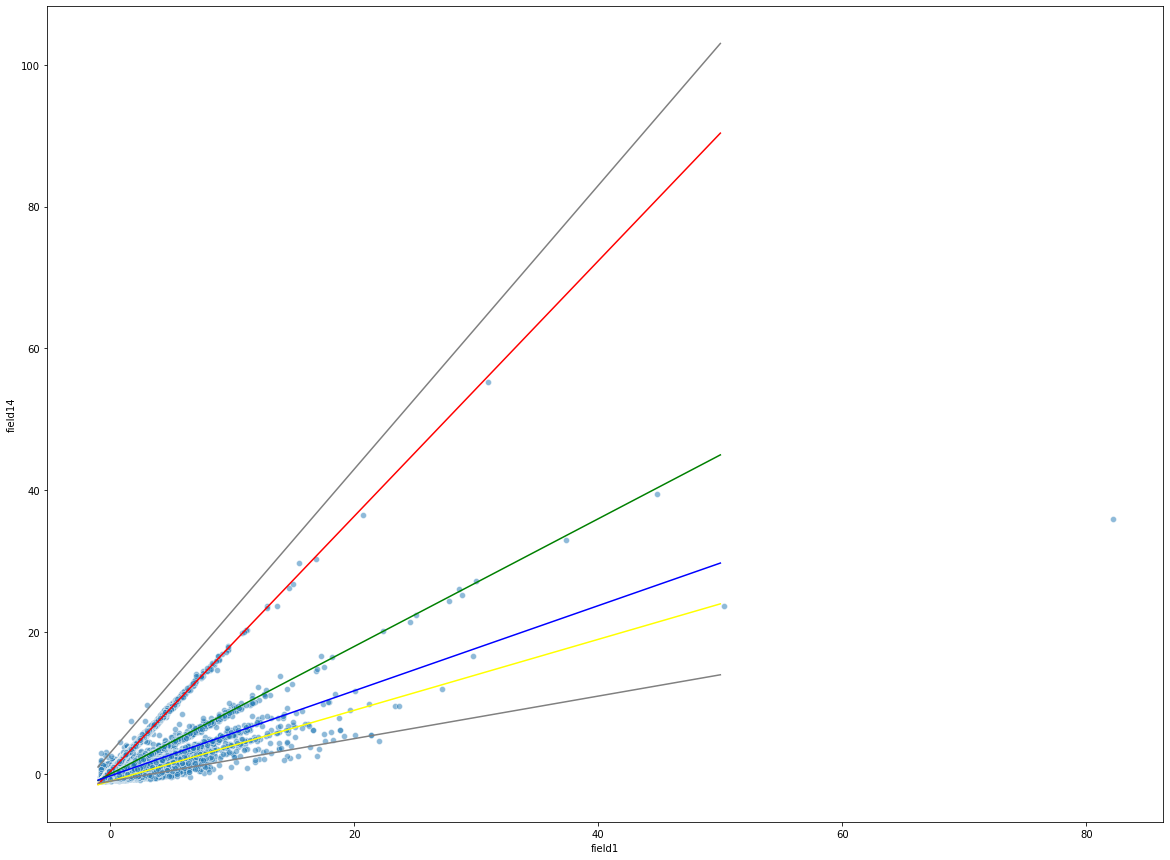

In [639]:
plt.figure(figsize=(20, 15))
sns.scatterplot(x='field1', y='field14', data=train, alpha=0.5);
x = np.linspace(-1, 50, 100)
sns.lineplot(x, 1.8 * x + 0.36, color='red');
sns.lineplot(x, 0.9 * x, color='green');
sns.lineplot(x, 0.6 * x - 0.25, color='blue');
sns.lineplot(x, 0.5 * x - 1, color='yellow');
sns.lineplot(x, 0.3 * x - 1, color='gray');
sns.lineplot(x, 2 * x + 3, color='gray');

Попробуем выделить эти линии. Для этого сделаем индикатор для каждой из этих линий.  
Рассчитаем для каждой точки расстояние до линий. И по минимальному расстоянию будем судить к какому классу отнести точку.  
Также добавим две линии для сбора шума и возьмем объединенный датасет для большего количества данных. И обрежем снизу по field1 и field14, чтобы линии не пересекались.

In [605]:
def dist_point_to_straight(x, y, a, b, c):
    return np.abs(a * x + b * y + c) / np.sqrt(a * a + b * b)

df_lines = full[(full['field1'] >= 0) & (full['field14'] >= 0)]
df_lines['red'] = dist_point_to_straight(df_lines['field1'], df_lines['field14'], 1.8, -1, 0.36)
df_lines['green'] = dist_point_to_straight(df_lines['field1'], df_lines['field14'], 0.9, -1, 0)
df_lines['blue'] = dist_point_to_straight(df_lines['field1'], df_lines['field14'], 0.6, -1, -0.25)
df_lines['yellow'] = dist_point_to_straight(df_lines['field1'], df_lines['field14'], 0.5, -1, -1)

df_lines['noise1'] = dist_point_to_straight(df_lines['field1'], df_lines['field14'], 0.3, -1, -1)
df_lines['noise2'] = dist_point_to_straight(df_lines['field1'], df_lines['field14'], 2, -1, 3)


df_lines['color'] = df_lines[['red', 'green', 'blue', 'yellow', 'noise1', 'noise2']].idxmin(axis=1)
df_lines = df_lines[(df_lines['color'] != 'noise1') & (df_lines['color'] != 'noise2')]
red = df_lines[df_lines['color'] == 'red']
green = df_lines[df_lines['color'] == 'green']
blue = df_lines[df_lines['color'] == 'blue']
yellow = df_lines[df_lines['color'] == 'yellow']

In [606]:
df_lines.shape

(141239, 51)

Получилось 20% от full. Это не так много, но это необходимая жертва, чтобы классы не пересекались и не были зашумлены.

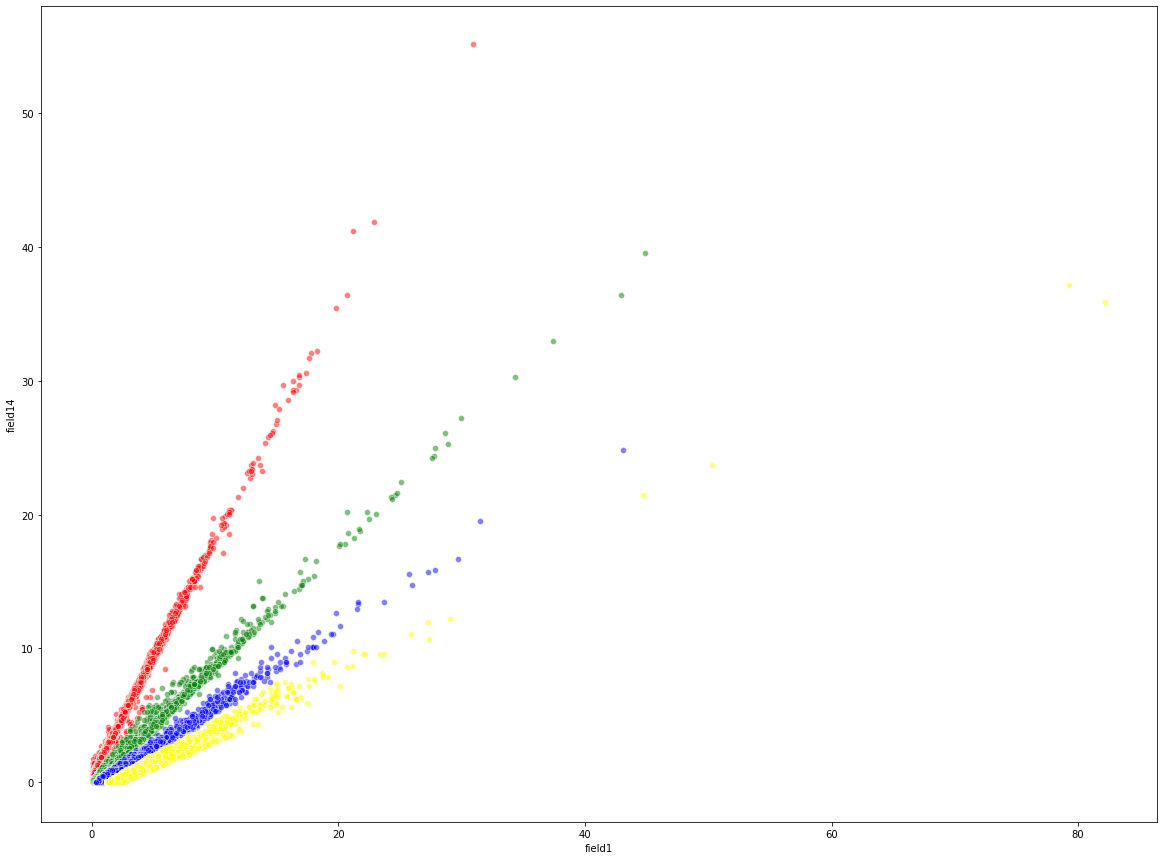

In [607]:
plt.figure(figsize=(20, 15))
sns.scatterplot(x='field1', y='field14', data=red, alpha=0.5, color='red');
sns.scatterplot(x='field1', y='field14', data=green, alpha=0.5, color='green');
sns.scatterplot(x='field1', y='field14', data=blue, alpha=0.5, color='blue');
sns.scatterplot(x='field1', y='field14', data=yellow, alpha=0.5, color='yellow');

In [608]:
red.shape[0], green.shape[0], blue.shape[0], yellow.shape[0]

(75498, 27615, 32589, 5537)

Есть предположение, что цвета это класс билета. На сайте OneTwoTrip можно выбрать один из четырех 'Эконом', 'Премиум', 'Бизнес' и 'Первый'.  
А field14 - это либо расстояние, либо время полета. Скорее второе, потому что при поиске билетов всегда указано время полета.  
Логично было бы нормализовать цену и время полета, чтобы участники соревнования не смогли восстановить точные данные.  
И также кажется логичным, что цена внутри одного класса зависит линейно от расстояния.

Скорее всего, человек в среднем пользуется какими-то соседними классами. Давайте проверим это. Возьмем людей, у которых больше 5 билетов. И посчитаем для них количество билетов каждого класса.

In [636]:
users = np.unique(df_lines[df_lines['flight_quantity'] > 5]['userid'])

row_list = []
for user in users:
    row_dict = dict()
    df_user = df_lines[df_lines['userid'] == user]
    row_dict['all'] = df_user.shape[0]
    row_dict['1'] = sum(df_user['color'] == 'red')
    row_dict['2'] = sum(df_user['color'] == 'green')
    row_dict['3'] = sum(df_user['color'] == 'blue')
    row_dict['4'] = sum(df_user['color'] == 'yellow')
    row_list.append(row_dict)

df_rgb = pd.DataFrame(row_list)
df_rgb = df_rgb[df_rgb['all'] > 5]

df_rgb['1_%'] = df_rgb['1'] / df_rgb['all']
df_rgb['2_%'] = df_rgb['2'] / df_rgb['all']
df_rgb['3_%'] = df_rgb['3'] / df_rgb['all']
df_rgb['4_%'] = df_rgb['4'] / df_rgb['all']
df_rgb['max_%'] = df_rgb[['1_%', '2_%', '3_%', '4_%']].idxmax(axis=1)

In [640]:
df_rgb.shape

(1108, 10)

Для каждого класса посчитали его процент от общего количества билетов. И для каждого человека нашли класс, которым он пользуется чаще всего.

In [641]:
df_rgb['max_%'].value_counts()

1_%    951
3_%     91
2_%     66
Name: max_%, dtype: int64

Заметим, что класс 4 не бывает самым популярным. 

Посмотрим, как меняется средний процент разных классов в зависимости от самого популярного класса у человека.

In [643]:
pd.DataFrame([df_rgb.mean(),
              df_rgb[(df_rgb['max_%'] == '1_%')].mean(),
              df_rgb[(df_rgb['max_%'] == '2_%')].mean(),
              df_rgb[(df_rgb['max_%'] == '3_%')].mean()],
             index=['general', '1', '2', '3'])

,all,1,2,3,4,1_%,2_%,3_%,4_%
general,11.721119,7.971119,1.644404,1.779783,0.325812,0.667322,0.145927,0.160434,0.026318
1,12.170347,8.966351,1.479495,1.436383,0.288118,0.744505,0.120021,0.115158,0.020317
2,8.393939,1.727273,4.575758,1.742424,0.348485,0.186534,0.559641,0.207700,0.046125
3,9.439560,2.098901,1.241758,5.395604,0.703297,0.209422,0.116602,0.599306,0.074670


Видно, что люди, кто чаще пользуется классом 2 и 3, также чаще пользуются и классами выше.  
А те, кто пользуется классом 1, наоборот реже пользуются классами 2, 3 и 4, чем в общем случае.

In [645]:
pd.DataFrame([red.describe().loc['mean'],
             green.describe().loc['mean'],
             blue.describe().loc['mean'],
             yellow.describe().loc['mean']])

,field0,field1,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field2,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,field3,field4,field5,field6,field7,field8,field9,goal1,goal21,goal22,goal23,goal24,goal25,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,orderid,flight_quantity,red,green,blue,yellow,noise1,noise2
mean,31.291067,0.599277,0.395494,14.090135,21.375149,52.776564,1.532790,1.013881,17.715026,6.469191,3.792617,2.058134,7.930660,4.040650,1.257954,83.444065,12.633129,1.003801,11.290352,4.733357,1.972516,0.000212,2.957244,7.858168,6.025921,0.541882,3.890196,1.574108,0.643686,0.009868,0.034770,0.067831,0.191759,0.048914,0.018655,0.007707,0.986808,0.992847,0.399030,0.625262,0.454144,188184.743132,10.007590,0.057885,0.738419,1.220405,1.997392,2.253772,1.192166
mean,28.118812,1.680444,0.492812,14.493609,23.882709,42.681188,1.343936,2.038928,29.581170,5.817816,3.822198,1.985660,7.943581,4.049068,1.195655,83.428825,12.285497,1.794677,13.270541,4.103241,1.702915,0.207677,2.957523,7.744125,3.747456,0.649575,5.434909,1.599348,0.603947,0.036574,0.036588,0.077135,0.288148,0.051344,0.019194,0.008757,0.991381,0.995111,0.429441,0.707731,0.462756,188611.294622,6.316857,0.991131,0.149232,0.502208,1.344963,1.762212,2.243649
mean,29.185093,1.150109,0.416460,14.623646,15.246617,34.731597,0.461638,2.410844,25.117555,4.368959,3.805272,1.976955,7.785787,4.066740,1.210869,49.755316,12.480929,2.093191,7.117555,4.297094,1.846390,0.260763,2.910092,7.670778,3.987695,0.609623,3.203136,1.442327,0.729940,0.056890,0.023998,0.058064,0.280456,0.053895,0.018202,0.021049,0.992789,0.987082,0.425972,0.701771,0.574028,188385.517046,6.884102,0.956016,0.426249,0.138644,0.792984,1.069514,2.163879
mean,27.181867,3.321506,0.464692,14.621817,18.883330,34.885136,0.825515,4.343869,36.506592,4.540726,3.849377,1.930287,7.814701,4.058696,1.187647,66.105833,12.293300,3.390825,10.672205,4.019325,1.747697,0.874842,2.905183,7.516525,4.145024,0.668593,6.043706,1.533502,0.694961,0.078201,0.034849,0.072652,0.401654,0.073243,0.018311,0.018901,0.990970,0.989344,0.430016,0.754380,0.551562,187068.002890,8.420986,2.677444,1.608370,0.786654,0.233653,0.794099,3.943304


Обратите внимание на field24 и field28.

# Anti-StandardScaler для Field1 и Field14  
К Field1 и Field14 применили стандартизацию $( \frac{X - \mu}{\sigma})$.

In [662]:
len(np.unique(full['field1']))

317

In [674]:
full['field1'].value_counts().head(10)

-0.548937    69415
-0.471365    68709
-0.393794    60662
-0.626508    53536
-0.316223    52086
-0.238651    43585
-0.161080    37066
-0.083509    31203
-0.005937    26032
 0.071634    21879
Name: field1, dtype: int64

Всего 317 уникальных значений на 651067. Очевидно, что это не непрерывная величина.  
Если внимательно посмотреть на эти десять значений, то можно заметить, что у них общий шаг

In [667]:
0.548937 - 0.471365, 0.471365 - 0.393794, 0.626508 - 0.548937

(0.07757200000000003, 0.077571, 0.07757099999999995)

Давайте поделим на него.

In [678]:
np.unique(full['field1'])[:20] / 0.077571

array([-11.07659051, -10.07658585,  -9.0765812 ,  -8.07657655,
        -7.0765719 ,  -6.07656724,  -5.07656259,  -4.07655794,
        -3.07655329,  -2.07654863,  -1.07654398,  -0.07653933,
         0.92346532,   1.92346997,   2.92347463,   3.92347928,
         4.92348393,   5.92348858,   6.92349324,   7.92349789])

Теперь очевидно повторяется дробная часть. Добавим ее.

In [684]:
np.unique(full['field1'])[:20] / 0.077571 + 0.0765905

array([-1.10000000e+01, -9.99999535e+00, -8.99999070e+00, -7.99998605e+00,
       -6.99998140e+00, -5.99997674e+00, -4.99997209e+00, -3.99996744e+00,
       -2.99996279e+00, -1.99995813e+00, -9.99953482e-01,  5.11702010e-05,
        1.00005582e+00,  2.00006047e+00,  3.00006513e+00,  4.00006978e+00,
        5.00007443e+00,  6.00007908e+00,  7.00008374e+00,  8.00008839e+00])

-11, -10, -9, ...  

In [688]:
np.round((np.unique(full['field1']) / 0.077571 + 0.0765905)).astype(int)

array([ -11,  -10,   -9,   -8,   -7,   -6,   -5,   -4,   -3,   -2,   -1,
          0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  1

Проделаем то же самое для field14.

In [689]:
np.round((np.unique(full['field14']) /  0.14006639 - 0.27860731)).astype(int)

array([ -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
         6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 151, 152, 153, 154, 157,
       160, 162, 164, 165, 166, 167, 169, 170, 173, 174, 177, 178, 180,
       181, 184, 185, 186, 187, 191, 193, 194, 199, 201, 204, 20

Этот способ я подглядел [здесь](https://www.coursera.org/learn/competitive-data-science/lecture/qJHOb/exploring-anonymized-data).

Скорее всего первоначальные цены округляли, поэтому получился такой шаг.  
На сайте OneTwoTrip время полета идет с шагом 5 минут.

In [702]:
unique14 = np.unique(full['field14'])
new_unique14 = np.round(unique14 / 0.14006639 - 0.27860731).astype(int)
dict14 = {unique14[i]: new_unique14[i] for i in range(len(unique14))}
train['field14_new'] = train['field14'].apply(lambda x: dict14[x])
test['field14_new'] = test['field14'].apply(lambda x: dict14[x])

unique1 = np.unique(full['field1'])
new_unique1 = np.round(unique1  / 0.077571 + 0.0765905).astype(int)
dict1 = {unique1[i]: new_unique1[i] for i in range(len(unique1))}
train['field1_new'] = train['field1'].apply(lambda x: dict1[x])
test['field1_new'] = test['field1'].apply(lambda x: dict1[x])

full = pd.concat([train, test])

# Field11

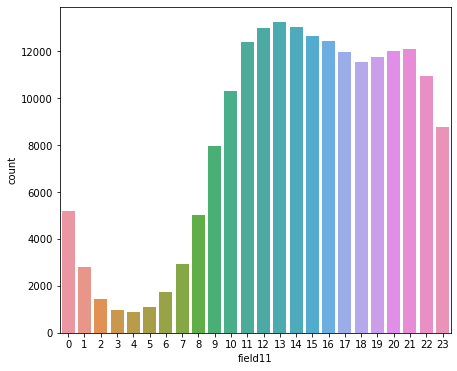

In [732]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.countplot(train['field11'], ax=ax);

[0, 23]. Спад в промежутке 0 - 8. Признак похож на час. Например, час вылета.

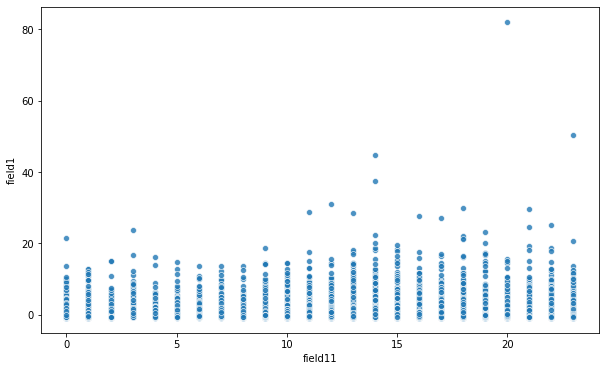

In [726]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='field11', y='field1', data=train, alpha=0.8, ax=ax);

Построим график средних значений field1.

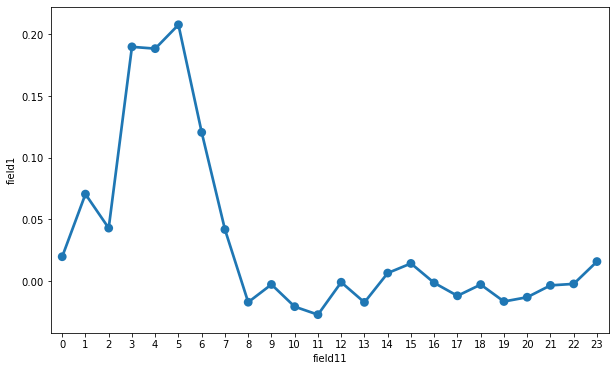

In [727]:
df11 = train.groupby(['field11'])[['field1']].mean()
df11.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.pointplot(x='field11', y='field1', data=df11, ax=ax);

В области 1-7 сильный выброс. Но по графику распределения field11 видно, что в этом время наоборот заметно меньше билетов.  
Возьмем какой-нибудь популярный рейс по продолжительности полета и изучим его.

In [750]:
full['field14_new'].value_counts().head()

-4    99056
-3    89226
-5    85765
-2    67232
-1    50935
Name: field14_new, dtype: int64

In [729]:
df_one = full[full['field14_new'] == -4]

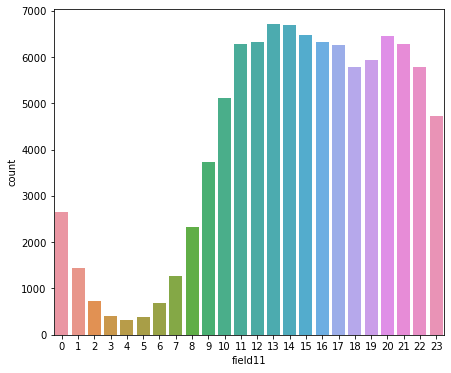

In [730]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.countplot(df_one['field11'], ax=ax);

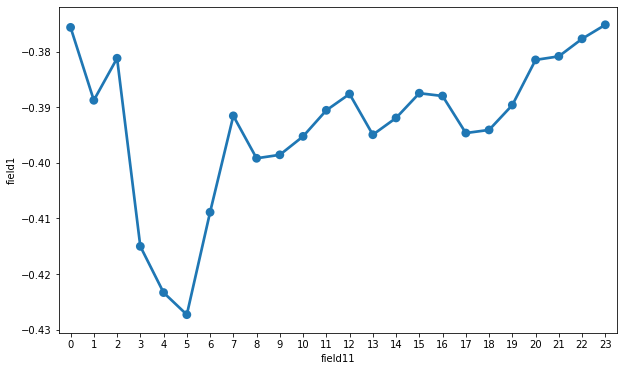

In [731]:
df11 = df_one.groupby(['field11'])[['field1']].mean()
df11.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.pointplot(x='field11', y='field1', data=df11, ax=ax);

Распределение не поменялось, но теперь совсем другой график зависимости field1 от field11.  
Теперь хорошо заметно, что чем позже, тем билеты дороже. Можете попробовать другие популярные рейсы с одинаковой продолжительностью полета. Да, это все еще не один рейс, но шума гораздо меньше. Так что вполне можно предположить, что field11 - это время отлета.

# Field2

Проделаем все то же самое, что и для field11

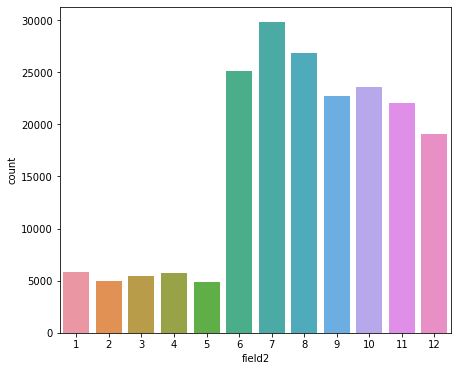

In [737]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.countplot(train['field2'], ax=ax);

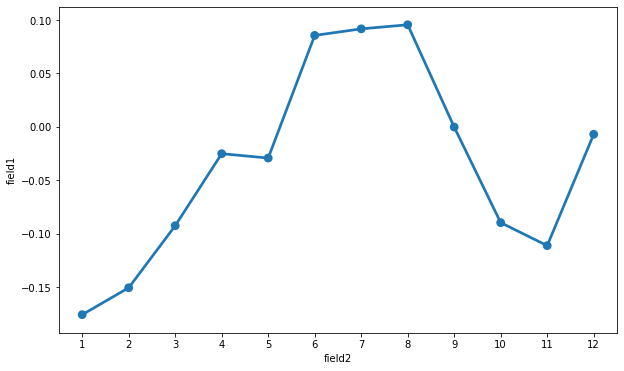

In [738]:
df11 = train.groupby(['field2'])[['field1']].mean()
df11.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.pointplot(x='field2', y='field1', data=df11, ax=ax);

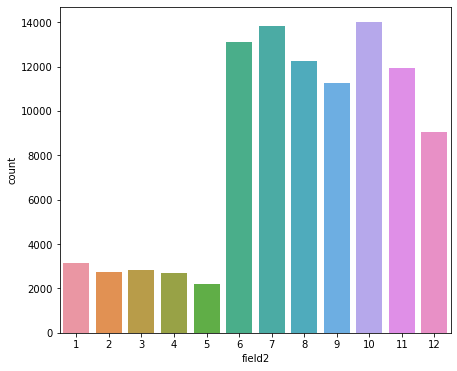

In [739]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.countplot(df_one['field2'], ax=ax);

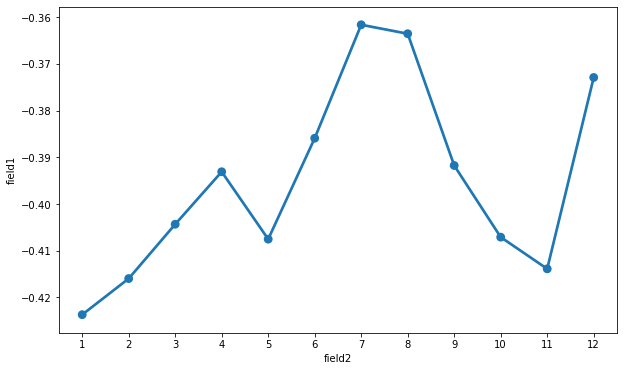

In [740]:
df11 = df_one.groupby(['field2'])[['field1']].mean()
df11.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.pointplot(x='field2', y='field1', data=df11, ax=ax);

Скорее всего field2 - это месяц вылета. Летом и в декабре дороже. Очень похоже на правду.

# Интересные зависимости,  
которые были получены просто перебором.

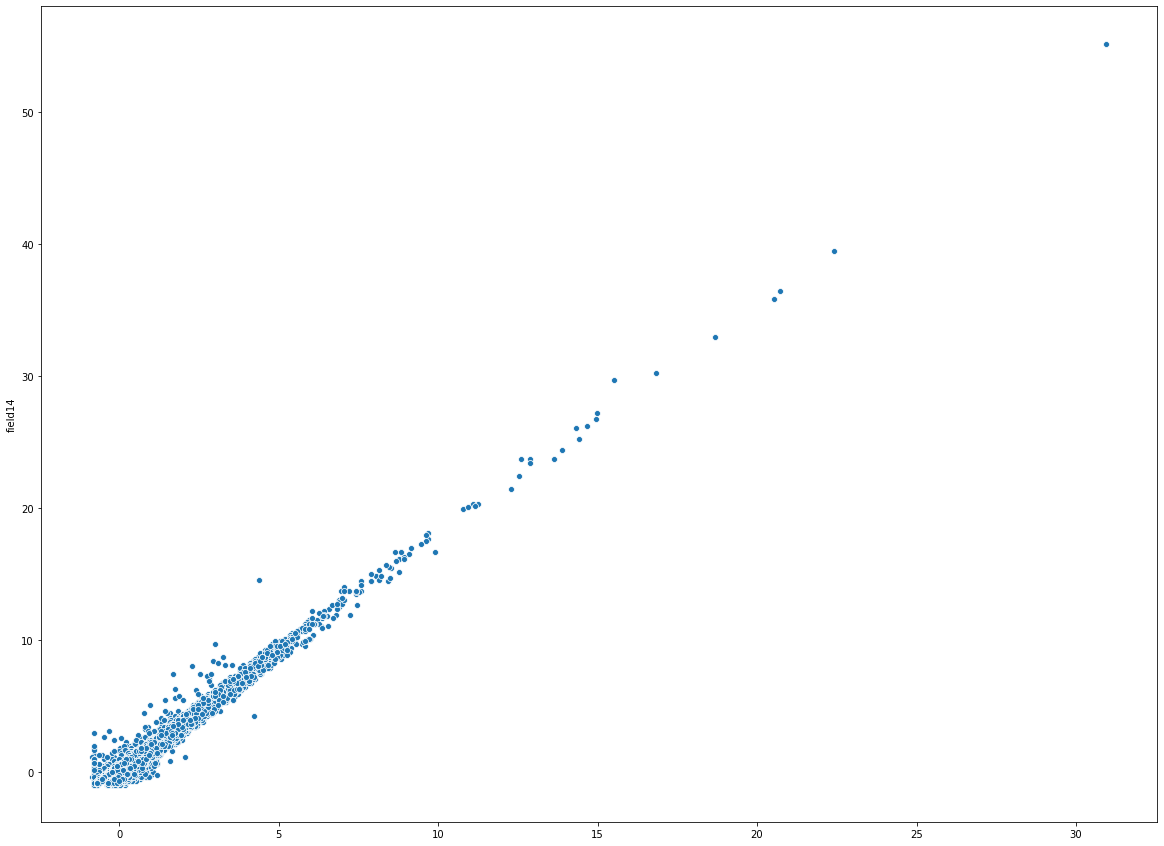

In [742]:
plt.figure(figsize=(20, 15))
a = train['field1'] / train['field15']
b = train['field14']
sns.scatterplot(x=a, y=b);

In [745]:
np.corrcoef(a, b)

array([[1.        , 0.92457458],
       [0.92457458, 1.        ]])

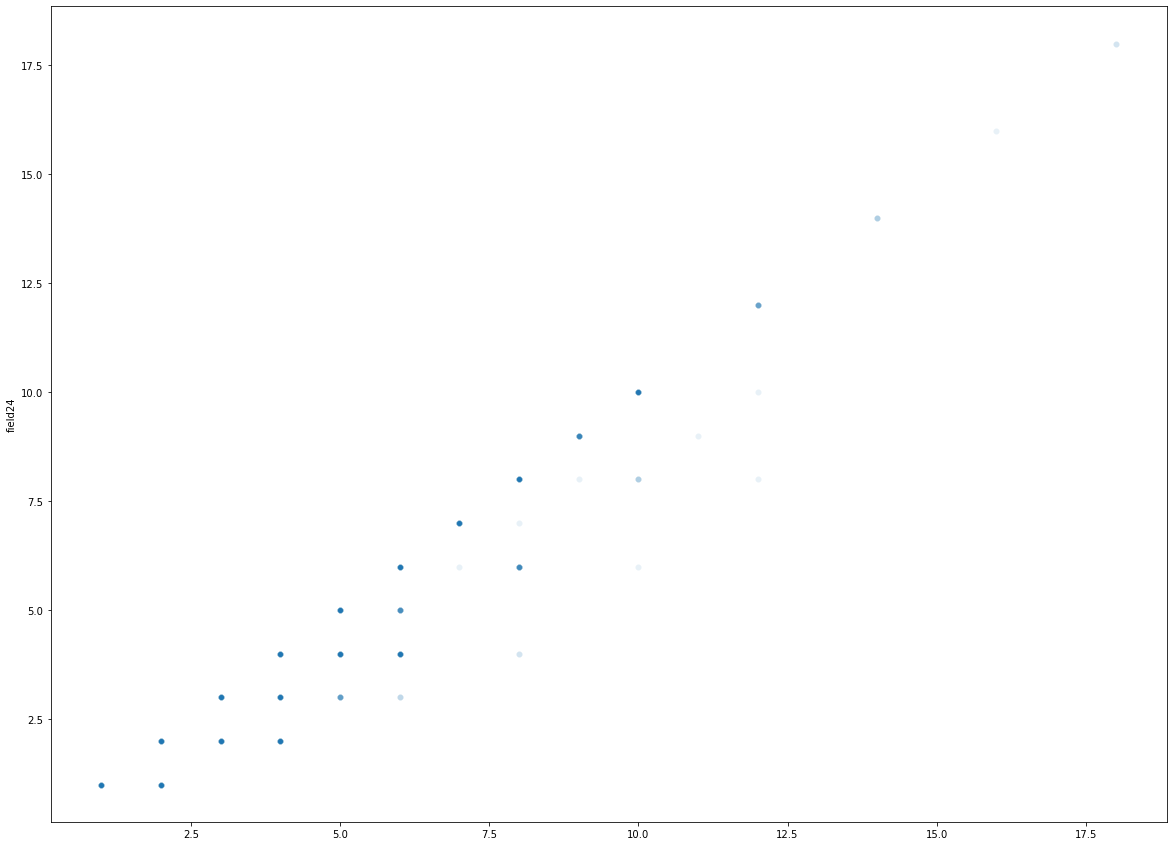

In [748]:
plt.figure(figsize=(20, 15))
a = train['field15'] - train['field28']
b = train['field24']
sns.scatterplot(x=a, y=b, alpha=0.1);

In [749]:
np.corrcoef(a, b)

array([[1.        , 0.97953474],
       [0.97953474, 1.        ]])